In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from functools import partial

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance

np.set_printoptions(threshold=5)  # to limit printing

from vflow import Vset, dict_to_df, compute_interval, build_vset, filter_vset_by_metric, init_args
from vflow.pipeline import build_graph

In [2]:
# initialize data
np.random.seed(13)

X, y = make_classification(n_samples=500, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)

def kfold_wrap(X, y, n_splits=4):
    kf = KFold(n_splits=n_splits)
    split_gen = kf.split(X)
    def yield_fold_k():
        train_idx, valid_idx = next(split_gen)
        return X[train_idx, :], X[valid_idx, :], y[train_idx], y[valid_idx]
    return [yield_fold_k for i in range(n_splits)]

# create k-fold splits lazily
k_fold_set = Vset(name = 'k_fold', modules=kfold_wrap(X_train, y_train, n_splits=4), lazy=True)

X_trains, X_valids, y_trains, y_valids = k_fold_set(n_out=4, keys=['X_train', 'X_valid', 'y_train', 'y_valid'])

def clean_data(*Xs, strategy = 'standardize'):
    out = []
    for X in Xs:
        if strategy == 'signlog':
            out.append(np.sign(X) * np.log(np.abs(X)))
        if strategy == 'standardize':
            scaler = StandardScaler()
            scaler.fit(X)
            out.append(scaler.transform(X))
        if strategy == 'none':
            out.append(X)
    if len(out) == 1:
        return out[0]
    else:
        return out

clean_param_dict = {
    'strategy': ['none', 'signlog', 'standardize']
}
data_clean_set = build_vset('data_cleaning', clean_data, clean_param_dict, output_matching=True, lazy=True)

# X_trains_clean, X_valids_clean = data_clean_set(X_trains, X_valids)
X_trains_clean = data_clean_set(X_trains)
X_valids_clean = data_clean_set(X_valids)

# build modeling Vset
rf_param_dict = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 10],
    'max_features': ['sqrt', 'log2']
}
rf_set = build_vset('RF', RandomForestClassifier, rf_param_dict)

In [3]:
rf_set.fit(X_trains_clean, y_trains)
preds_valid = rf_set.predict(X_valids_clean)

# get metrics
binary_metrics_set = Vset(name='binary_metrics',
                          modules=[accuracy_score, balanced_accuracy_score],
                          module_keys=["Acc", "Bal_Acc"])
binary_metrics = binary_metrics_set.evaluate(preds_valid, y_valids)

In [4]:
dict_to_df(binary_metrics)

,k_fold-1,k_fold,data_cleaning,k_fold-0,k_fold-2,RF,k_fold-3,binary_metrics,out
0,X_valid,k_fold_0,"(strategy=none,)",X_train,y_train,"(n_estimators=100, min_samples_split=2, max_fe...",y_valid,Acc,0.940000
1,X_valid,k_fold_1,"(strategy=none,)",X_train,y_train,"(n_estimators=100, min_samples_split=2, max_fe...",y_valid,Acc,0.900000
2,X_valid,k_fold_2,"(strategy=none,)",X_train,y_train,"(n_estimators=100, min_samples_split=2, max_fe...",y_valid,Acc,0.970000
3,X_valid,k_fold_3,"(strategy=none,)",X_train,y_train,"(n_estimators=100, min_samples_split=2, max_fe...",y_valid,Acc,0.920000
4,X_valid,k_fold_0,"(strategy=signlog,)",X_train,y_train,"(n_estimators=100, min_samples_split=2, max_fe...",y_valid,Acc,0.880000
...,...,...,...,...,...,...,...,...,...
187,X_valid,k_fold_3,"(strategy=signlog,)",X_train,y_train,"(n_estimators=200, min_samples_split=10, max_f...",y_valid,Bal_Acc,0.808523
188,X_valid,k_fold_0,"(strategy=standardize,)",X_train,y_train,"(n_estimators=200, min_samples_split=10, max_f...",y_valid,Bal_Acc,0.919711
189,X_valid,k_fold_1,"(strategy=standardize,)",X_train,y_train,"(n_estimators=200, min_samples_split=10, max_f...",y_valid,Bal_Acc,0.873745
190,X_valid,k_fold_2,"(strategy=standardize,)",X_train,y_train,"(n_estimators=200, min_samples_split=10, max_f...",y_valid,Bal_Acc,0.920368


/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


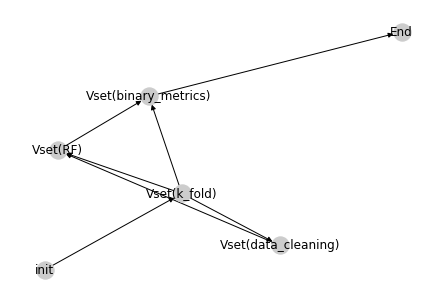

In [5]:
build_graph(binary_metrics)

In [6]:
# prediction check: filter rf_set and data_clean_set
filtered_rf_set, filtered_data_clean_set = filter_vset_by_metric(binary_metrics, rf_set, data_clean_set, n_keep=3, filter_on=['Bal_Acc'], group=True)

print(filtered_rf_set.modules)
print(filtered_data_clean_set.modules)

{(('n_estimators=100', 'min_samples_split=2', 'max_features=sqrt'),): <vflow.vfunc.Vfunc object at 0x7f2f95293c40>, (('n_estimators=100', 'min_samples_split=10', 'max_features=log2'),): <vflow.vfunc.Vfunc object at 0x7f2f9529dc70>, (('n_estimators=200', 'min_samples_split=10', 'max_features=log2'),): <vflow.vfunc.Vfunc object at 0x7f2f9529df40>}
{(('strategy=none',),): <vflow.vfunc.Vfunc object at 0x7f2f95279c10>}


In [7]:
# refit best models to to X_train, y_train
X_train, y_train = init_args((X_train, y_train), ['X_train', 'y_train'])
X_train_clean = filtered_data_clean_set(X_train)

filtered_rf_set.fit(X_train_clean, y_train)

importance_set = build_vset('perm_importance',
                            permutation_importance,
                            n_repeats=30)

X_test, y_test = init_args((X_test, y_test), ['X_test', 'y_test'])
X_test_clean = filtered_data_clean_set(X_test)

importances = importance_set.evaluate(filtered_rf_set.out, X_test_clean, y_test)

In [8]:
dict_to_df(importances)

,init-data_cleaning,data_cleaning,init-RF,RF,init-perm_importance,init-perm_importance,perm_importance,out
0,X_train,"(strategy=none,)",y_train,"(n_estimators=100, min_samples_split=2, max_fe...",X_test,y_test,(),"{'importances_mean': [0.01733333333333335, -0...."
1,X_train,"(strategy=none,)",y_train,"(n_estimators=100, min_samples_split=10, max_f...",X_test,y_test,(),"{'importances_mean': [0.028333333333333256, 0...."
2,X_train,"(strategy=none,)",y_train,"(n_estimators=200, min_samples_split=10, max_f...",X_test,y_test,(),"{'importances_mean': [0.010000000000000038, -0..."


/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


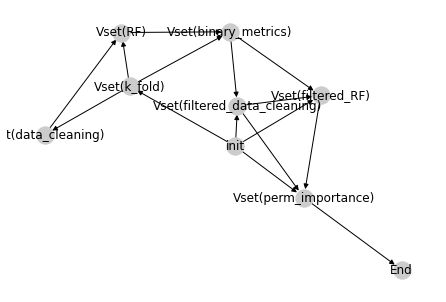

In [9]:
build_graph(importances)